In [1]:
import pymc3 as pm
import numpy as np
import scipy as sp
import pandas as pd
import common
import matplotlib.pyplot as plt
import os
plt.rcParams["font.size"] = 30
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [48]:
# データへのパス
DIR_PATH = "/Users/kumada/Data/小松/2019_03_15"
HASAKI_NAMES = "hasaki_names.npy"
HASAKI = "hasaki.npy"
MAMOURYO_NAMES = "mamouryo_names.npy"
MAMOURYO = "mamouryo.npy"
SESSAKU_NAMES = "sessaku_names.npy"
SESSAKU = "sessaku.npy"

In [49]:
# データ読み込み
hasaki_names = np.load(os.path.join(DIR_PATH, HASAKI_NAMES))
hasaki = np.load(os.path.join(DIR_PATH, HASAKI))
mamouryo_names = np.load(os.path.join(DIR_PATH, MAMOURYO_NAMES))
mamouryo = np.load(os.path.join(DIR_PATH, MAMOURYO))
sessaku_names = np.load(os.path.join(DIR_PATH, SESSAKU_NAMES))
sessaku = np.load(os.path.join(DIR_PATH, SESSAKU))
print(hasaki_names.shape)
print(hasaki.shape)
print(mamouryo_names.shape)
print(mamouryo.shape)
print(sessaku_names.shape)
print(sessaku.shape)

(37,)
(37, 50)
(3,)
(3, 50)
(16,)
(16, 50)


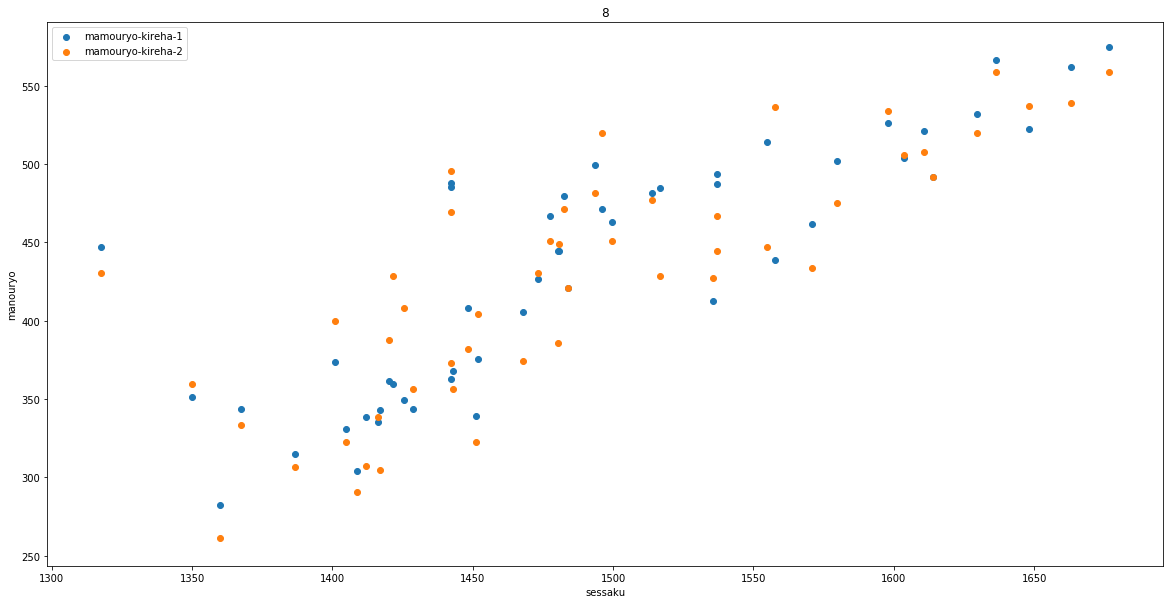

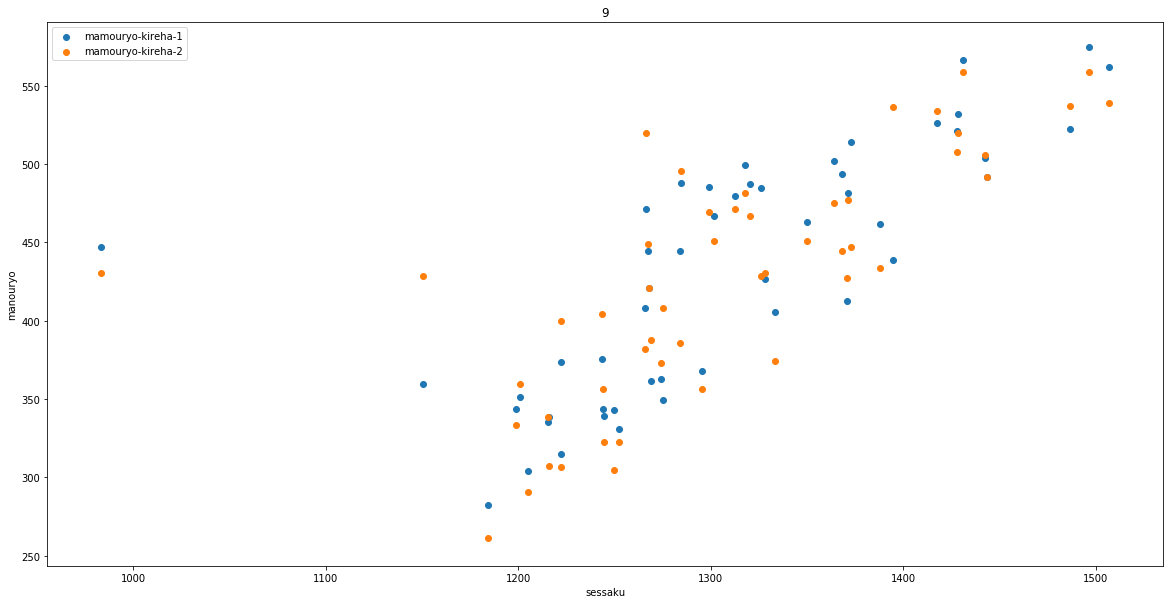

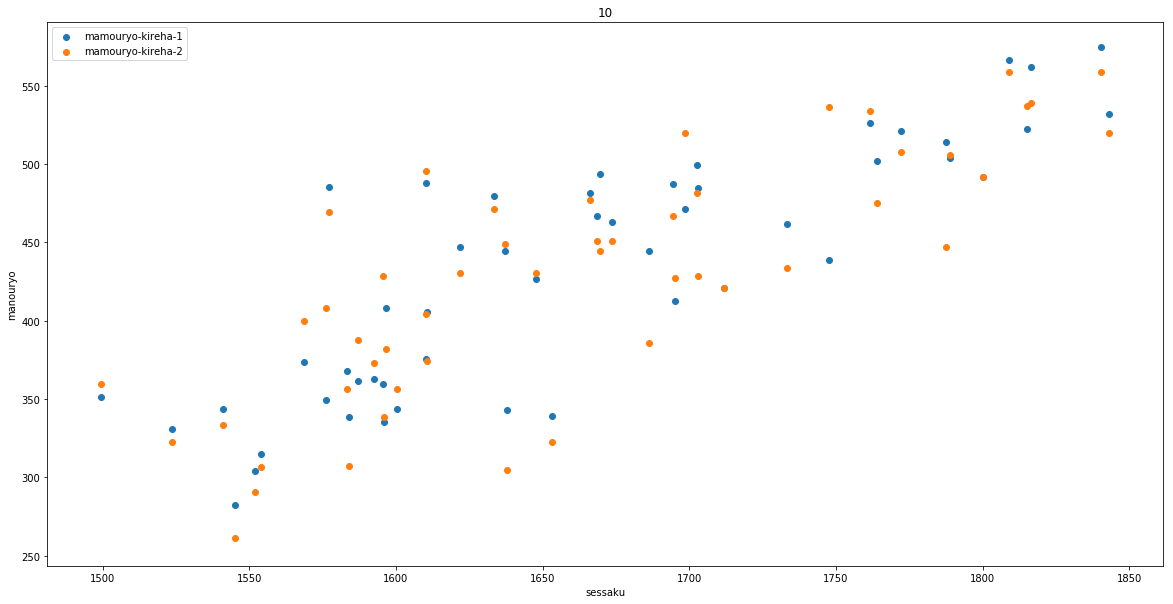

In [120]:
mamouryo_index = 0
y0 = mamouryo[0]
y1 = mamouryo[1]
# データ描画
for index in [8, 9, 10]: 
    X = sessaku[index][:, None]
    plt.figure(figsize=(20, 10))
    plt.scatter(X, y0, label="mamouryo-kireha-1")
    plt.scatter(X, y1, label="mamouryo-kireha-2")
    plt.xlabel("sessaku")
    plt.ylabel("manouryo")
    plt.title(str(index))
    plt.legend(loc="best")
    plt.show()

In [117]:
# 以下の3つを考える。横軸：X
for i in [8, 9, 10]:
    print(sessaku_names[i])

寿命_切削力_ｽﾗｽﾄ_平均値
寿命_切削力_ｽﾗｽﾄ_最小値
寿命_切削力_ｽﾗｽﾄ_最大値


縦軸は磨耗量切れ刃1

# 寿命\_切削力\_ｽﾗｽﾄ\_平均値 vs 磨耗量切れ刃1

In [131]:
raw_y = mamouryo[0]
raw_X = sessaku[8][:, None]
print(raw_y.shape, raw_X.shape)

(50,) (50, 1)


In [148]:
# X軸に沿ってソートする。
X_index = np.argsort(raw_X, axis=0)
X = raw_X[X_index].squeeze()[:, None]
y = raw_y[X_index].squeeze()
print(X.shape)
print(y.shape)

(50, 1)
(50,)


In [149]:
# 　yの最大値を1最小値を-1に
y_max = np.max(y)
y_min = np.min(y)

def scale(v):
    return 2 * (v - y_min) / (y_max - y_min) - 1

y = [scale(v) for v in y]

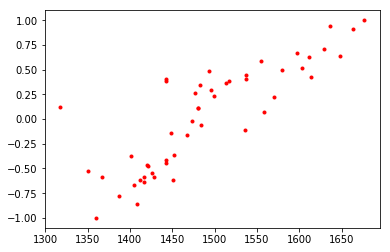

In [150]:
plt.plot(X, y, 'r.')
plt.show()

In [151]:
y_mean = np.mean(y)
y_std = np.std(y)
y = [(v - y_mean) / y_std for  v in y]

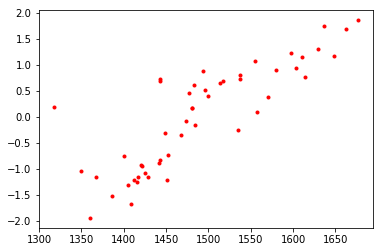

In [152]:
plt.plot(X, y, 'r.')
plt.show()

In [155]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)

    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, f_rotated_, η, ℓ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:37<00:00, 79.36draws/s] 
/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The number of effective samples is smaller than 25% for some parameters.


In [193]:
type(trace)

pymc3.backends.base.MultiTrace

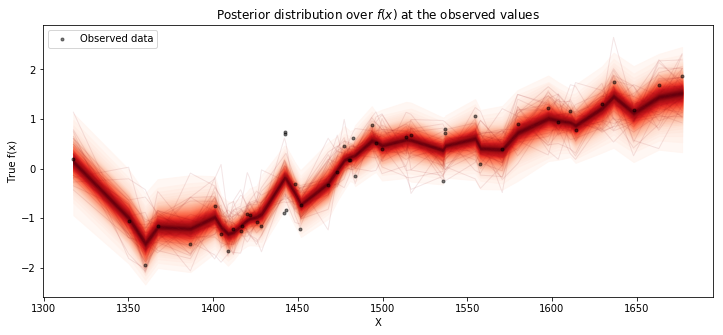

In [157]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
# fの事後確率を描画
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
# plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();


In [158]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(1300, 1800, n_new)[:,None]

# add the GP conditional to the model, given the new X values
# 条件付き確率を作る。
with model:
    f_pred = gp.conditional("f_pred", X_new)

# 上で作成した確率からサンプルする。
# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:17<00:00, 58.25it/s]


/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


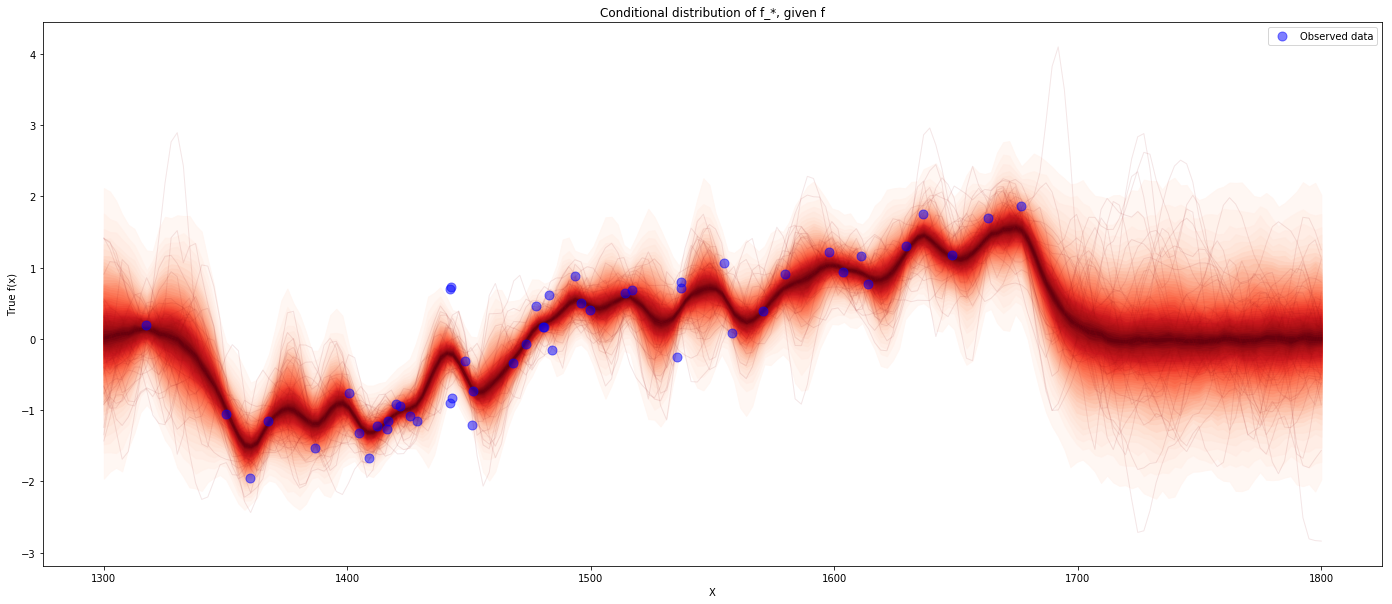

In [165]:
fig = plt.figure(figsize=(24,10)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X, y, 'ob', markersize=9, ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Conditional distribution of f_*, given f"); 
plt.legend();

In [169]:
pred_samples["f_pred"].shape

(1000, 200)

In [171]:
type(pred_samples["f_pred"])

numpy.ndarray

In [186]:
f_pred = pred_samples["f_pred"]
row, col = f_pred.shape
means = []
stds = []
for i in range(col):
    means.append(np.mean(f_pred[:, i]))
    stds.append(np.std(f_pred[:, i]))    
means = np.array(means)
stds = np.array(stds)
print(means.shape)
print(stds.shape)

(200,)
(200,)


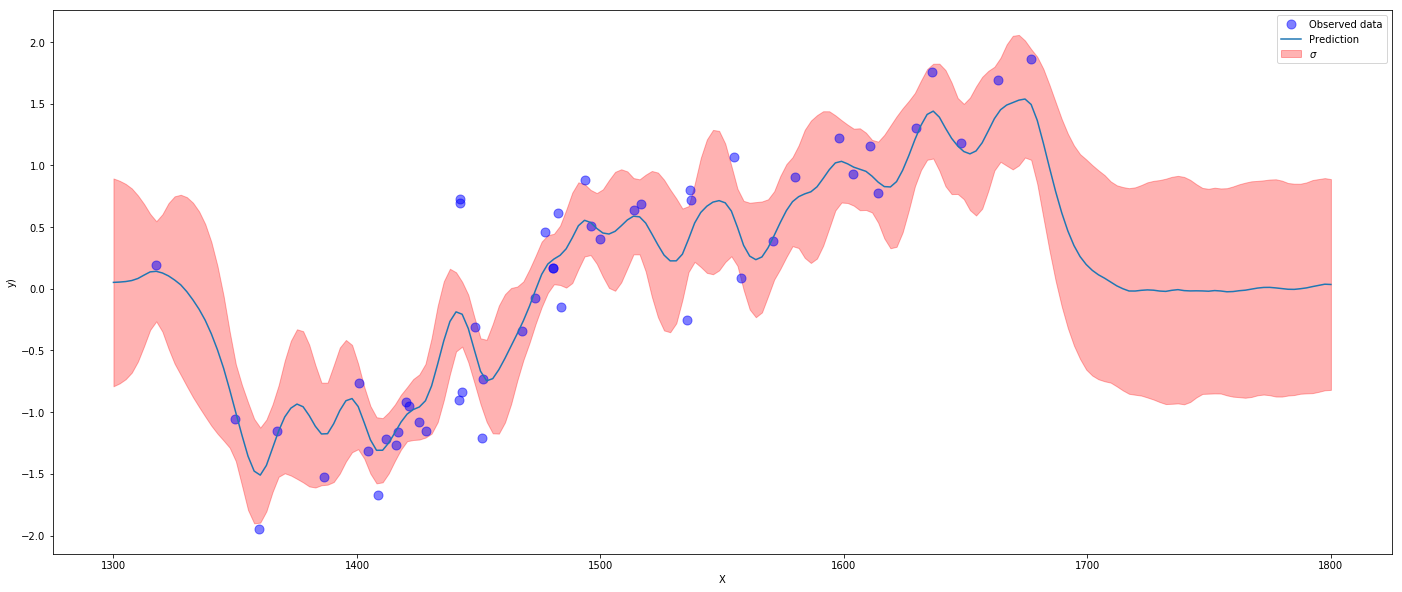

In [192]:
fig = plt.figure(figsize=(24,10)); 
ax = fig.gca()
plt.plot(X, y, 'ob', ms=9, alpha=0.5, label="Observed data");
plt.plot(X_new, means, label="Prediction")
plt.fill_between(X_new.squeeze(), means - stds, means + stds, color='red', alpha=0.3, label="$\sigma$")
plt.xlabel("X"); 
plt.ylabel("y)");
plt.legend(loc="best");
plt.show()